Перетворюємо Json в таблицю

In [1]:
import json
import pandas as pd

EXPORT_FOLDER = 'output-data'

with open('result.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

messages = data['messages']

df = pd.json_normalize(messages)

df

,id,type,date,date_unixtime,from,from_id,file,file_name,file_size,thumbnail,...,edited_unixtime,reactions,duration_seconds,reply_to_message_id,forwarded_from,actor,actor_id,action,discard_reason,self_destruct_period_seconds
0,179368,message,2023-03-30T00:45:24,1680126324,Friend,user836495468,(File not included. Change data exporting sett...,sticker.webp,21982.0,(File not included. Change data exporting sett...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,179369,message,2023-03-30T00:45:39,1680126339,User,user625856657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179370,message,2023-03-30T00:45:43,1680126343,User,user625856657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,179371,message,2023-03-30T00:45:45,1680126345,User,user625856657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,179372,message,2023-03-30T00:45:48,1680126348,User,user625856657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,521397,message,2025-04-08T15:39:57,1744115997,User,user625856657,NaN,NaN,NaN,NaN,...,1744133306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4616,521420,message,2025-04-08T23:09:34,1744142974,User,user625856657,(File not included. Change data exporting sett...,NaN,435270.0,(File not included. Change data exporting sett...,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4617,521421,message,2025-04-08T23:09:46,1744142986,User,user625856657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4618,521422,message,2025-04-08T23:17:26,1744143446,Friend,user836495468,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


З колонки <i>reactions</i> витягаємо смайли реакцій

In [2]:
df['reaction_count'] = df['reactions'].apply(
    lambda x: x[0]['count'] 
    if isinstance(x, list) and len(x) > 0 and 'count' in x[0] 
    else None
)

df['reaction_emoji'] = df['reactions'].apply(
    lambda x: x[0]['emoji'] 
    if isinstance(x, list) and len(x) > 0 and 'count' in x[0] 
    else None
)

In [3]:
emoji_df = df[['date', 'from', 'reaction_emoji', 'reaction_count']]

emoji_df = emoji_df.dropna(subset=['reaction_emoji'])

emoji_df


,date,from,reaction_emoji,reaction_count
5,2023-03-30T00:45:50,User,❤,1.0
13,2023-03-30T00:50:45,Friend,❤‍🔥,1.0
16,2023-03-30T00:51:09,Friend,❤‍🔥,1.0
27,2023-06-04T18:03:41,User,❤,1.0
30,2023-06-04T18:04:16,User,❤,1.0
...,...,...,...,...
4544,2025-04-02T16:12:47,User,❤,1.0
4565,2025-04-08T14:49:20,User,❤,1.0
4575,2025-04-08T14:51:11,User,❤,1.0
4587,2025-04-08T14:55:38,User,❤,1.0


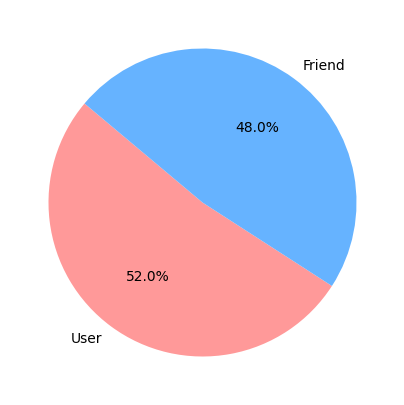

In [4]:
import matplotlib.pyplot as plt

message_counts = df['from'].value_counts().reset_index()

labels = message_counts['from']
sizes = message_counts['count']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff'])
plt.show()


Групуємо за реакціями на повідомлення

In [5]:
grouped = emoji_df.groupby(['from', 'reaction_emoji'])['reaction_count'].sum().reset_index()
grouped.to_csv(f"{EXPORT_FOLDER}/reaction_emoji_grouped.csv", index=False, encoding='utf-8-sig')

In [6]:
df = df[['date', 'from', 'file', 'text', 'media_type', 'photo', 'edited', 'duration_seconds', 'reaction_count', 'reaction_emoji']]

Групуємо за типом медіа

In [7]:
media_type = df[~df['media_type'].isnull()].copy()
media_type = media_type[['from', 'media_type', 'date']]
media_type_grouped = media_type.groupby(['from', 'media_type'])['date'].sum().reset_index()
media_type_grouped.to_csv(f"{EXPORT_FOLDER}/media_type_grouped.csv", index=False, encoding='utf-8-sig')

Групуємо за місяцем

In [8]:
df.loc[:, 'year_month'] = df['date'].str[:7] 
date_grouped = df.groupby(['from', 'year_month'])['date'].count().reset_index()
date_grouped = date_grouped.pivot(index='year_month', columns='from', values='date').reset_index()
date_grouped.to_csv(f"{EXPORT_FOLDER}/date_grouped_by_month.csv", index=False, encoding='utf-8-sig')

C:\Users\b.yarinko\AppData\Local\Temp\ipykernel_20924\1722791903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year_month'] = df['date'].str[:7]


In [9]:
text_df = df[['date', 'from', 'text']].copy()
text_df = text_df[text_df['text'] != '']
text_df

,date,from,text
2,2023-03-30T00:45:43,User,но піздєц
3,2023-03-30T00:45:45,User,ще й ліміт
4,2023-03-30T00:45:48,User,ну добре
5,2023-03-30T00:45:50,User,кину окремо
6,2023-03-30T00:46:12,User,So here we go.
...,...,...,...
4614,2025-04-08T15:12:16,Friend,Але чисто якіс хуйні😂
4615,2025-04-08T15:39:57,User,"[{'type': 'link', 'text': 'https://www.youtube..."
4617,2025-04-08T23:09:46,User,"Єбать, Федя"
4618,2025-04-08T23:17:26,Friend,Ні дякую мені вже скинув стас


Теплова карта

Text(145.72222222222223, 0.5, 'Day of Week')

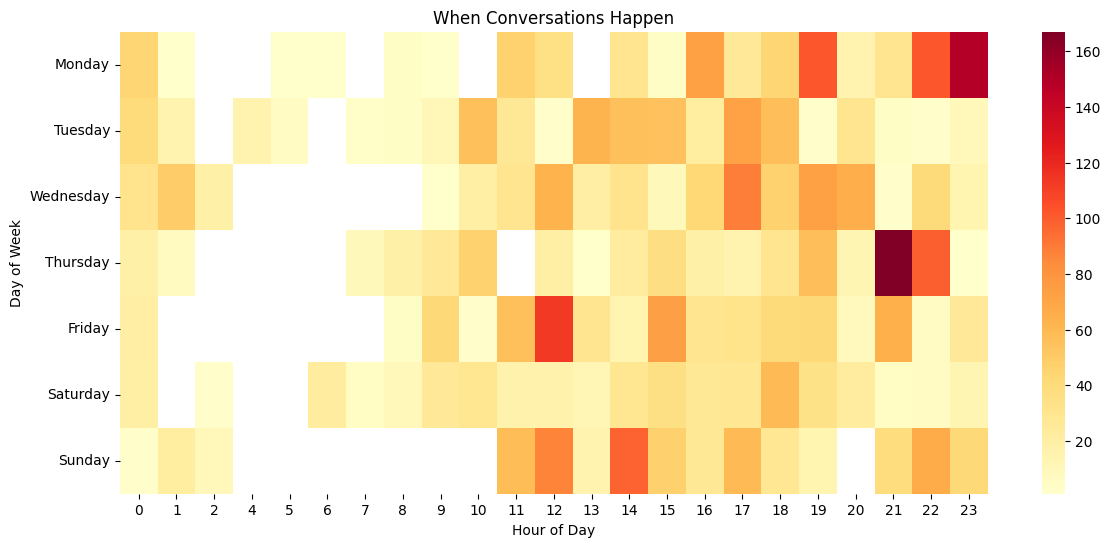

In [10]:
import calendar
import seaborn as sns

text_df['date'] = pd.to_datetime(text_df['date'])

hour_day = text_df.groupby([text_df['date'].dt.dayofweek, text_df['date'].dt.hour]).size().unstack()
hour_day.index = [calendar.day_name[day] for day in hour_day.index]
plt.figure(figsize=(14, 6))
sns.heatmap(hour_day, cmap='YlOrRd')
plt.title('When Conversations Happen')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

Перетворюємо датафрейм для візуалізації у Flourish

In [11]:
hour_day_reset = hour_day.reset_index()  # Скидаємо індекс, щоб 'Day' став стовпцем
hour_day_melted = hour_day_reset.melt(id_vars=['index'], var_name='Hour', value_name='Value')
hour_day_melted.rename(columns={'index': 'Day'}, inplace=True)
hour_day_melted.to_csv(f"{EXPORT_FOLDER}/hour_day.csv", index=False, encoding='utf-8-sig')
hour_day_melted

,Day,Hour,Value
0,Monday,0,44.0
1,Tuesday,0,40.0
2,Wednesday,0,31.0
3,Thursday,0,18.0
4,Friday,0,21.0
...,...,...,...
156,Wednesday,23,14.0
157,Thursday,23,1.0
158,Friday,23,26.0
159,Saturday,23,13.0


Хмара слів

Text(0.5, 1.0, 'Most Frequent Words')

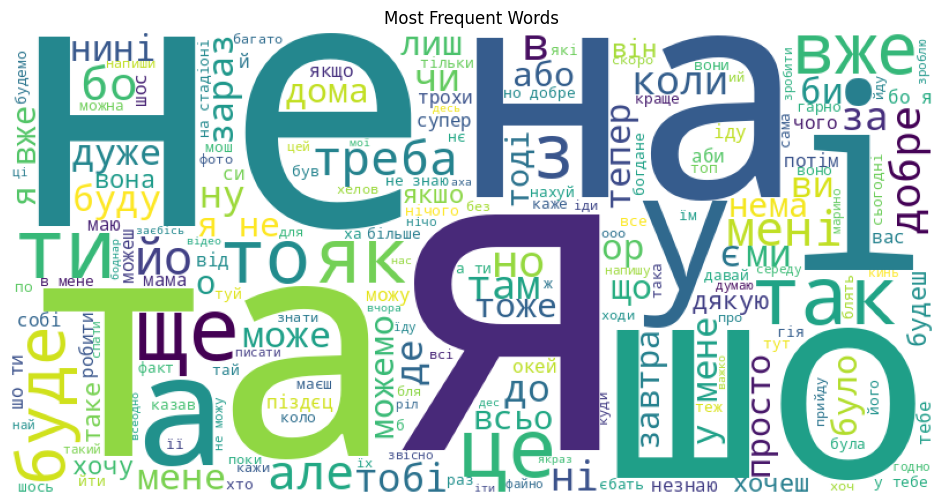

In [12]:
from wordcloud import WordCloud

text = ' '.join(text.lower() if isinstance(text, str) else '' for text in text_df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequent Words')


Середня довжина повідомлення

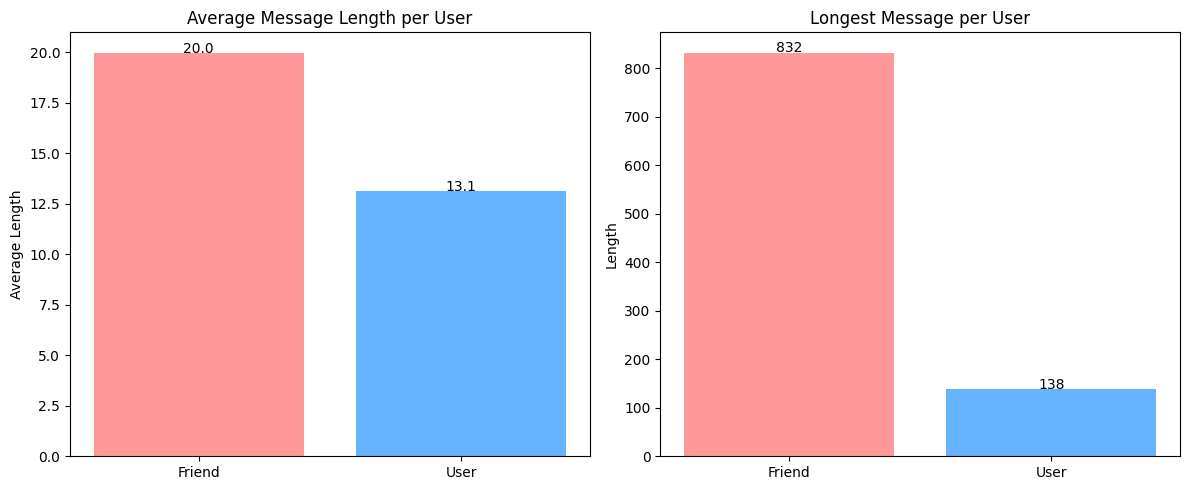

In [13]:
text_df['length'] = text_df['text'].apply(len)

# Calculate average and maximum message lengths
avg_length = text_df.groupby('from')['length'].mean().reset_index()
avg_length.rename(columns={'length': 'avg_length'}, inplace=True)

max_length = text_df.groupby('from')['length'].max().reset_index()
max_length.rename(columns={'length': 'max_length'}, inplace=True)
length_stats = pd.merge(avg_length, max_length, on='from')

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(avg_length['from'], avg_length['avg_length'], color=['#ff9999', '#66b3ff'])
for i, v in enumerate(avg_length['avg_length']):
    axes[0].text(i, v, f'{v:.1f}', ha='center')
axes[0].set_title('Average Message Length per User')
axes[0].set_ylabel('Average Length')

axes[1].bar(max_length['from'], max_length['max_length'], color=['#ff9999', '#66b3ff'])
for i, v in enumerate(max_length['max_length']):
    axes[1].text(i, v + 1, f'{v}', ha='center')
axes[1].set_title('Longest Message per User')
axes[1].set_ylabel('Length')

plt.tight_layout()
plt.show()